## Full Modeling Pipeline - LightGBM

Pipeline includes:
- Data load 
- Data processing
- Feature engineering
- Model running with different hyperparameters
- Model evaluation
- Predict test data

In [1]:
import os
import gc
import time
import psutil
import pickle
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
%matplotlib inline

plt.style.use('ggplot')

In [2]:
from contextlib import contextmanager

@contextmanager
def timer(name):
    """ @author: lopuhin @address https://www.kaggle.com/lopuhin/ """
    start_time = time.time()
    yield
    print('[{} done in {:.3f} s.]'.format(name, time.time() - start_time))
    
def reduce_memory_usage(df):
    """ @author: gemartin @address: https://www.kaggle.com/gemartin """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    dtypes = {}
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                    dtypes[col] = np.int8
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                    dtypes[col] = np.int16
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                    dtypes[col] = np.int32
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                    dtypes[col] = np.int64
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                    dtypes[col] = np.float16
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                    dtypes[col] = np.float32
                else:
                    df[col] = df[col].astype(np.float64)
                    dtypes[col] = np.float64
        else: 
            df[col] = df[col].astype('category')
            dtypes[col] = 'category'
    
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.2f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df, dtypes

In [3]:
def extract_datetime_components(df, cols, drop_raw=False):
    if isinstance(cols, str):
        cols = [cols]

    for col in cols:
        df[col] = pd.to_datetime(df[col])
        df[col + '_day']    = df[col].dt.day.astype(np.int8)
        df[col + '_hour']   = df[col].dt.hour.astype(np.int8)
        
    if drop_raw:
        df.drop(labels=cols, axis=1, inplace=True)

    return df

def add_group_stats(df, cols, value, method):
    if not isinstance(value, str):
        raise NotImplementedError('Only support value to be string format (column name)')

    if isinstance(method, str):
        method = [method]

    method_options = ['nunique', 'count', 'mean', 'median', 'std', 
                      'var', 'max', 'min', 'sum', 'skew', 'kurtosis']
    if any([True if m not in method_options else False for m in method]):
        raise AttributeError('Only support method in {}.'.format(method_options))

    if isinstance(cols, str):
        cols = [cols]

    new_cols = ['_'.join([*cols, value, m]) if m != 'count' else '_'.join([*cols, m]) for m in method]

    df_feats = pd.DataFrame(df.groupby(cols)[value].agg(method)).reset_index()
    df_feats.columns = cols + new_cols
    df = df.merge(df_feats, on=cols, how='left')
    
    # convert data types to save memory
    for col in new_cols:
        c_min = df[col].min()
        c_max = df[col].max()
        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
            df[col] = df[col].astype(np.int8)
        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
            df[col] = df[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
            df[col] = df[col].astype(np.int32)
        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
            df[col] = df[col].astype(np.int64)
            
    return df, new_cols

def process_data(df, groupby_extraction_setting, groupby_extraction_for_timedetla):
    # datetime
    df = extract_datetime_components(df, cols=['click_time'])
    
    # group by on categorical
    for setting in groupby_extraction_setting:
        cols = setting[0]
        for value, method in setting[1]:
            df, _ = add_group_stats(df, cols, value, method)
    
    # timedelta
    for groupby_cols in groupby_extraction_for_timedetla:
        click_time = df[groupby_cols + ['click_time']].sort_values('click_time')
        prevfix = '_'.join(groupby_cols)
        click_time[f'{prevfix}_click_time_prev1'] = click_time.groupby(groupby_cols)['click_time'].shift(1)
        click_time[f'{prevfix}_click_time_prev2'] = click_time.groupby(groupby_cols)['click_time'].shift(2)
        df[f'{prevfix}_click_time_prev1_diff'] = (click_time['click_time'] - click_time[f'{prevfix}_click_time_prev1']).dt.seconds
        df[f'{prevfix}_click_time_prev2_diff'] = (click_time['click_time'] - click_time[f'{prevfix}_click_time_prev2']).dt.seconds
    
    df.drop(columns=['click_time'], axis=1, inplace=True)
    df, dtypes = reduce_memory_usage(df)
    return df, dtypes

In [4]:
with timer('Load full training data'):
    data_path = '../input/talkingdata-adtracking-fraud-detection/'
    
    nov_7_start = 9308568
    nov_7_end   = 68941877

    nov_8_start = 68941878
    nov_8_end   = 131886952
    
    nov_9_start = 131886953
    nov_9_4     = 144708152
    nov_9_15    = 181878211
    
    read_dtypes = {
        'ip':            'uint32',
        'app':           'uint16',
        'device':        'uint16',
        'os':            'uint16',
        'channel':       'uint16',
        'click_id':      'uint32'
    }
    
    train_cols = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
    test_cols = ['ip', 'app', 'device', 'os', 'channel', 'click_time']
    
    # read training data on 11/07 and 11/09
    train = pd.read_csv(os.path.join(data_path, 'train.csv'),
                        dtype=read_dtypes,
                        skiprows=range(1, nov_7_start + 1),
                        nrows=nov_9_4 - nov_7_start,
                        usecols=train_cols)
   
    # sample (save memory)
    train_pos_samples = train.loc[train['is_attributed'] == 1]
    train_neg_samples = train.loc[train['is_attributed'] == 0].sample(frac=0.05)
    del train
    train = pd.concat([train_pos_samples, train_neg_samples], ignore_index=True)
    train = train.sample(frac=1.0, replace=False, random_state=2020)
    # https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/56279
    train = train.loc[train['device'] != 3032]
    print(f'Training data size: {train.shape}')
    
    valid = pd.read_csv(os.path.join(data_path, 'train.csv'),
                        dtype=read_dtypes,
                        skiprows=range(1, nov_9_4 + 1),
                        nrows=nov_9_15 - nov_9_4,
                        usecols=train_cols)
    valid = valid.loc[valid['device'] != 3032]
    valid = valid.sample(frac=0.05, replace=False, random_state=2020)
    print(f'Validation data size: {valid.shape}')

Training data size: (7061679, 7)
Validation data size: (1858503, 7)
[Load full training data done in 374.562 s.]


In [5]:
with timer('Process data'):
    groupby_extraction_setting = [
        # 2 way combination
        (['ip'], [('os', 'count'),
                  ('os', 'nunique'),
                  ('app', 'nunique'),
                  ('device', 'nunique'),
                  ('channel', 'nunique')]),
        (['os'], [('ip', 'count')]),
        (['app'], [('ip', 'count')]),
        (['device'], [('ip', 'count')]),
        (['channel'], [('ip', 'count')]),
        (['click_time_hour'], [('ip', 'count')]),

        # 3 way combination
        (['ip', 'os'], [('app', 'count')]),
        (['ip', 'app'], [('os', 'count')]),
        (['ip', 'device'], [('os', 'count')]),
        (['ip', 'channel'], [('os', 'count')]),
        (['ip', 'click_time_hour'], [('os', 'count')]),

        # 4 way combination
        # (['ip', 'os', 'app'], [('device', 'count')]),
        (['ip', 'os', 'device'], [('app', 'count')]),
        # (['ip', 'os', 'channel'], [('app', 'count')]),
        (['ip', 'os', 'click_time_hour'], [('app', 'count')]),
        (['ip', 'app', 'device'], [('os', 'count')]),
        # (['ip', 'app', 'channel'], [('os', 'count')]),
        # (['ip', 'app', 'click_time_hour'], [('os', 'count')]),
        (['ip', 'device', 'channel'], [('os', 'count')]),
        (['ip', 'device', 'click_time_hour'], [('os', 'count')]),
        (['ip', 'channel', 'click_time_hour'], [('os', 'count')]),

        # 5 way combination
        (['ip', 'os', 'app', 'device'], [('channel', 'count')]),
        # (['ip', 'os', 'app', 'channel'], [('device', 'count')]),
        (['ip', 'os', 'app', 'click_time_hour'], [('device', 'count')]),
        # (['ip', 'os', 'device', 'channel'], [('app', 'count')]),
        (['ip', 'os', 'device', 'click_time_hour'], [('app', 'count')]),
        (['ip', 'os', 'channel', 'click_time_hour'], [('app', 'count')]),
        # (['ip', 'app', 'device', 'channel'], [('os', 'count')]),
        (['ip', 'app', 'channel', 'click_time_hour'], [('os', 'count')]),
        # (['ip', 'app', 'device', 'click_time_hour'], [('os', 'count')]),
        (['ip', 'device', 'channel', 'click_time_hour'], [('os', 'count')]),
    ]
    
    groupby_extraction_for_timedetla = [
        ['ip', 'device', 'os'],
        ['ip', 'app', 'channel'],
        ['ip', 'device', 'os', 'app'],
        ['ip', 'device', 'os', 'channel']
    ]
    
    train, train_dtypes = process_data(train, groupby_extraction_setting, groupby_extraction_for_timedetla)
    valid, valid_dtypes = process_data(valid, groupby_extraction_setting, groupby_extraction_for_timedetla)
    gc.collect()

Memory usage of dataframe is 1077.53 MB
Memory usage after optimization is: 814.88 MB
Decreased by 24.38%
Memory usage of dataframe is 269.41 MB
Memory usage after optimization is: 171.92 MB
Decreased by 36.18%
[Process data done in 261.590 s.]


In [6]:
with timer('Get feature names'):
    columns = train.columns.tolist()
    for col in ['ip', 'is_attributed', 'click_time_day']:
        columns.remove(col)

    categorical_features = ['app', 'device', 'os', 'channel', 'click_time_hour']
    numerical_features = [f for f in columns if f not in categorical_features]
    features = categorical_features.copy() + numerical_features.copy()
    target = 'is_attributed'

[Get feature names done in 0.000 s.]


In [7]:
with timer('Setup LGB data'):
    
    X_train_lgb = lgb.Dataset(train[features], train[target], 
                              feature_name=features, 
                              categorical_feature=categorical_features,
                              free_raw_data=False)
    del train
    gc.collect()
    
    X_valid_lgb = lgb.Dataset(valid[features], valid[target], 
                              feature_name=features, 
                              categorical_feature=categorical_features,
                              free_raw_data=False)
    valid_pred = pd.DataFrame()
    gc.collect()

[Setup LGB data done in 0.621 s.]


In [8]:
with timer('Run LGB'):
    # default
    lgb_params = {
        'application': 'cross_entropy', # regression / classification
        'metric': 'auc',                # metric = AUC
        'learning_rate': 0.05,          # 
        'max_depth': 7,                 # max depth of decision tree
        'num_leaves': 30,               # number leaves
        'min_data_in_leaf': 120,        # minimum sample size required for forming a leaf
        'feature_fraction': 0.8,        # fraction of features to be sampled in each split
        'bagging_fraction': 1,          # fraction of samples to be used for training decision tree
        'data_random_seed': 2020,       # 
        'scale_pos_weight': 200,        # 
        'nthread': 8
    }
    
    lgb_model = lgb.train(lgb_params
                          , train_set=X_train_lgb
                          , valid_sets=[X_train_lgb, X_valid_lgb]
                          , num_boost_round=3000
                          , early_stopping_rounds=200
                          , verbose_eval=100)
    valid_pred['default'] = lgb_model.predict(valid[features])

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.975803	valid_1's auc: 0.964222
[200]	training's auc: 0.978157	valid_1's auc: 0.965837
[300]	training's auc: 0.979251	valid_1's auc: 0.966247
[400]	training's auc: 0.980035	valid_1's auc: 0.966506
[500]	training's auc: 0.980676	valid_1's auc: 0.966589
[600]	training's auc: 0.981275	valid_1's auc: 0.966606
[700]	training's auc: 0.981762	valid_1's auc: 0.966617
[800]	training's auc: 0.982175	valid_1's auc: 0.966702
[900]	training's auc: 0.982601	valid_1's auc: 0.966684
[1000]	training's auc: 0.982989	valid_1's auc: 0.966803
[1100]	training's auc: 0.983317	valid_1's auc: 0.966831
[1200]	training's auc: 0.98364	valid_1's auc: 0.966792
Early stopping, best iteration is:
[1094]	training's auc: 0.983298	valid_1's auc: 0.966836
[Run LGB done in 2006.009 s.]


In [9]:
with timer('Run LGB'):
    # less features
    # feature_fraction -> 0.5
    lgb_params = {
        'application': 'cross_entropy',
        'metric': 'auc',
        'learning_rate': 0.05,
        'max_depth': 7,
        'num_leaves': 30,
        'min_data_in_leaf': 120,
        'feature_fraction': 0.5,
        'bagging_fraction': 1,
        'data_random_seed': 2020,
        'scale_pos_weight': 200,
        'nthread': 8
    }
    
    lgb_model = lgb.train(lgb_params
                          , train_set=X_train_lgb
                          , valid_sets=[X_train_lgb, X_valid_lgb]
                          , num_boost_round=3000
                          , early_stopping_rounds=200
                          , verbose_eval=100)
    valid_pred['feature_frac=0.5'] = lgb_model.predict(valid[features])

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.975333	valid_1's auc: 0.962911
[200]	training's auc: 0.977743	valid_1's auc: 0.965208
[300]	training's auc: 0.978738	valid_1's auc: 0.965885
[400]	training's auc: 0.979484	valid_1's auc: 0.966096
[500]	training's auc: 0.98004	valid_1's auc: 0.966369
[600]	training's auc: 0.980592	valid_1's auc: 0.966521
[700]	training's auc: 0.981086	valid_1's auc: 0.966576
[800]	training's auc: 0.981513	valid_1's auc: 0.966698
[900]	training's auc: 0.98192	valid_1's auc: 0.966724
[1000]	training's auc: 0.982276	valid_1's auc: 0.966777
[1100]	training's auc: 0.982604	valid_1's auc: 0.966767
[1200]	training's auc: 0.982901	valid_1's auc: 0.966831
[1300]	training's auc: 0.983198	valid_1's auc: 0.96692
[1400]	training's auc: 0.98348	valid_1's auc: 0.966944
[1500]	training's auc: 0.983724	valid_1's auc: 0.966934
[1600]	training's auc: 0.983979	valid_1's auc: 0.966949
[1700]	training's auc: 0.984238	valid_1's auc: 0.96696


In [10]:
with timer('Run LGB'):
    # more regularization
    # max_depth -> 6
    # min_data_in_leaf -> 200
    lgb_params = {
        'application': 'cross_entropy',
        'metric': 'auc',
        'learning_rate': 0.05,
        'max_depth': 6,
        'num_leaves': 30,
        'min_data_in_leaf': 200,
        'feature_fraction': 0.5,
        'bagging_fraction': 1,
        'data_random_seed': 2020,
        'scale_pos_weight': 200,
        'nthread': 8
    }
    
    lgb_model = lgb.train(lgb_params
                          , train_set=X_train_lgb
                          , valid_sets=[X_train_lgb, X_valid_lgb]
                          , num_boost_round=3000
                          , early_stopping_rounds=200
                          , verbose_eval=100)
    valid_pred['more_regularization'] = lgb_model.predict(valid[features])

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.97519	valid_1's auc: 0.962978
[200]	training's auc: 0.977583	valid_1's auc: 0.965293
[300]	training's auc: 0.978529	valid_1's auc: 0.965881
[400]	training's auc: 0.979271	valid_1's auc: 0.966128
[500]	training's auc: 0.979839	valid_1's auc: 0.966371
[600]	training's auc: 0.980367	valid_1's auc: 0.966476
[700]	training's auc: 0.980799	valid_1's auc: 0.966587
[800]	training's auc: 0.98118	valid_1's auc: 0.96667
[900]	training's auc: 0.981549	valid_1's auc: 0.966808
[1000]	training's auc: 0.981905	valid_1's auc: 0.966899
[1100]	training's auc: 0.982222	valid_1's auc: 0.966978
[1200]	training's auc: 0.982492	valid_1's auc: 0.967044
[1300]	training's auc: 0.982776	valid_1's auc: 0.967096
[1400]	training's auc: 0.98305	valid_1's auc: 0.967159
[1500]	training's auc: 0.983312	valid_1's auc: 0.967176
[1600]	training's auc: 0.983549	valid_1's auc: 0.967271
[1700]	training's auc: 0.983768	valid_1's auc: 0.967288

In [11]:
with timer('Run LGB'):
    # less regularization
    # max_depth -> 8
    # min_data_in_leaf -> 80
    lgb_params = {
        'application': 'cross_entropy',
        'metric': 'auc',
        'learning_rate': 0.05,
        'max_depth': 8,
        'num_leaves': 30,
        'min_data_in_leaf': 80,
        'feature_fraction': 0.5,
        'bagging_fraction': 1,
        'data_random_seed': 2020,
        'scale_pos_weight': 200,
        'nthread': 8
    }
    
    lgb_model = lgb.train(lgb_params
                          , train_set=X_train_lgb
                          , valid_sets=[X_train_lgb, X_valid_lgb]
                          , num_boost_round=3000
                          , early_stopping_rounds=200
                          , verbose_eval=100)
    valid_pred['less_regularization'] = lgb_model.predict(valid[features])

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.975326	valid_1's auc: 0.962648
[200]	training's auc: 0.977787	valid_1's auc: 0.965015
[300]	training's auc: 0.978783	valid_1's auc: 0.965714
[400]	training's auc: 0.979606	valid_1's auc: 0.966042
[500]	training's auc: 0.980291	valid_1's auc: 0.966119
[600]	training's auc: 0.980827	valid_1's auc: 0.966335
[700]	training's auc: 0.981349	valid_1's auc: 0.966392
[800]	training's auc: 0.981772	valid_1's auc: 0.966533
[900]	training's auc: 0.982168	valid_1's auc: 0.966642
[1000]	training's auc: 0.982561	valid_1's auc: 0.96665
[1100]	training's auc: 0.98289	valid_1's auc: 0.966634
Early stopping, best iteration is:
[961]	training's auc: 0.982407	valid_1's auc: 0.966708
[Run LGB done in 1638.567 s.]


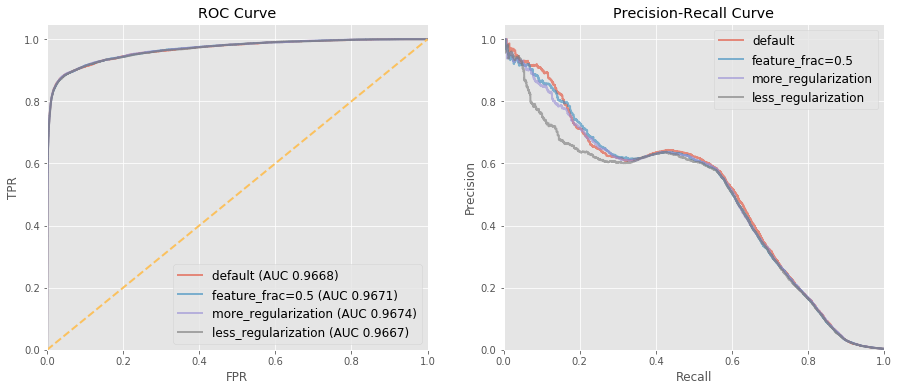

In [12]:
# false positive rate and true positive rate
fpr_1,  tpr_1,  thresholds_1  = roc_curve(valid[target].values, valid_pred['default'].values)
fpr_2,  tpr_2,  thresholds_2  = roc_curve(valid[target].values, valid_pred['feature_frac=0.5'].values)
fpr_3,  tpr_3,  thresholds_3  = roc_curve(valid[target].values, valid_pred['more_regularization'].values)
fpr_4,  tpr_4,  thresholds_4  = roc_curve(valid[target].values, valid_pred['less_regularization'].values)

roc_auc_1  = auc(fpr_1, tpr_1)
roc_auc_2  = auc(fpr_2, tpr_2)
roc_auc_3  = auc(fpr_3, tpr_3)
roc_auc_4  = auc(fpr_4, tpr_4)

# precision and recall
precision_1,  recall_1,  _  = precision_recall_curve(valid[target].values, valid_pred['default'].values)
precision_2,  recall_2,  _  = precision_recall_curve(valid[target].values, valid_pred['feature_frac=0.5'].values)
precision_3,  recall_3,  _  = precision_recall_curve(valid[target].values, valid_pred['more_regularization'].values)
precision_4,  recall_4,  _  = precision_recall_curve(valid[target].values, valid_pred['less_regularization'].values)

# ROC curve
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr_1, tpr_1,
         fpr_2, tpr_2,
         fpr_3, tpr_3,
         fpr_4, tpr_4, lw = 2, alpha = 0.6)

plt.plot([0, 1], [0, 1], lw = 2, linestyle = "--")
plt.xlim([0., 1.])
plt.ylim([0., 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend([f'default (AUC {roc_auc_1:.4f})', 
            f'feature_frac=0.5 (AUC {roc_auc_2:.4f})',
            f'more_regularization (AUC {roc_auc_3:.4f})',
            f'less_regularization (AUC {roc_auc_4:.4f})'], fontsize = 12)

# Precision - Recall 
plt.subplot(1, 2, 2)
plt.step(recall_1, precision_1, 
         recall_2, precision_2,
         recall_3, precision_3,
         recall_4, precision_4, lw = 2, alpha = 0.6)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0., 1.])
plt.ylim([0., 1.05])
plt.title('Precision-Recall Curve')
plt.legend(['default',
            'feature_frac=0.5',
            'more_regularization',
            'less_regularization'], fontsize = 12)
plt.show()

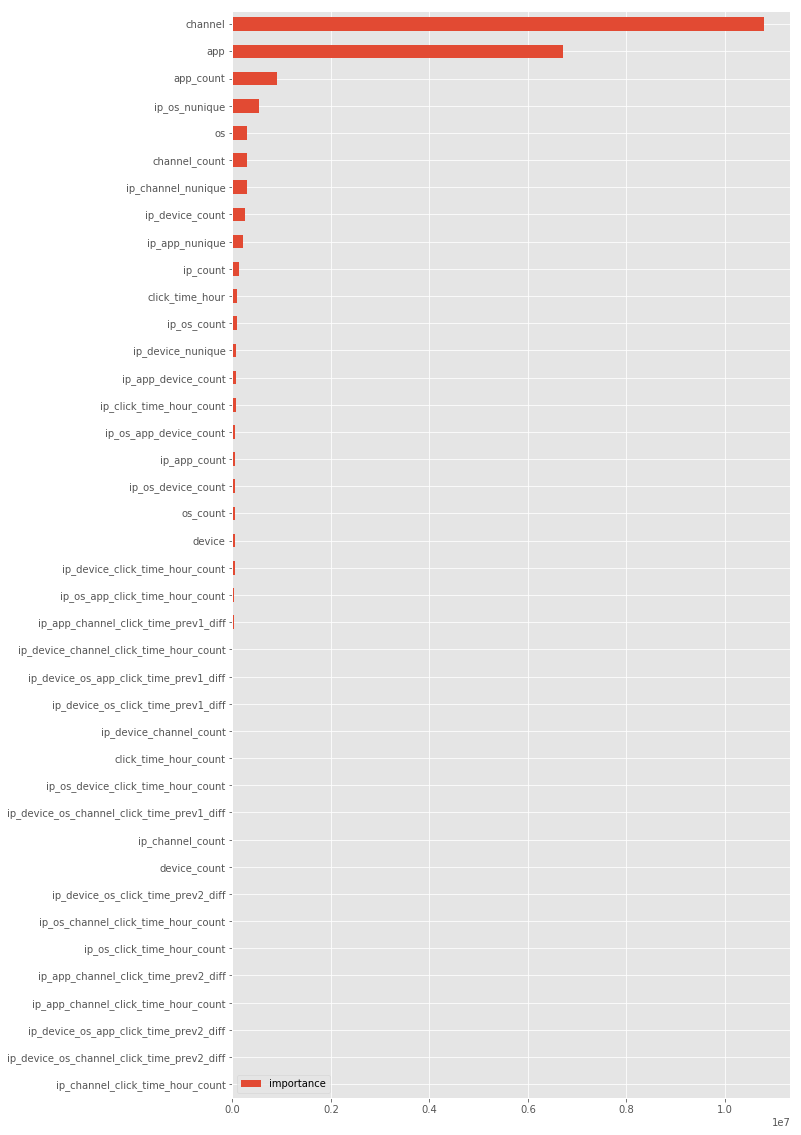

In [13]:
feature_importance_df = pd.DataFrame(lgb_model.feature_importance(importance_type='gain'), # importance_type='split'
                                     index=lgb_model.feature_name(),
                                     columns=['importance'])
_ = feature_importance_df.sort_values('importance', ascending=True).plot(kind='barh', figsize=(10, 20))

In [ ]:
with timer('Make predictions'):
    del X_train_lgb, X_valid_lgb
    # read test data
    test = pd.read_csv(os.path.join(data_path, 'test.csv'),
                       dtype=read_dtypes,
                       usecols=test_cols)
    print(f'Test data size: {test.shape}')
    
    test, test_dtypes = process_data(test, groupby_extraction_setting, groupby_extraction_for_timedetla)
    gc.collect()
    
    submission = pd.read_csv(
        '../input/talkingdata-adtracking-fraud-detection/sample_submission.csv')
    test_pred = lgb_model.predict(test[features].values)
    submission['is_attributed'] = test_pred
    submission.to_csv('submission.csv', index=False)